In [1]:
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
import obspy
from obspy.clients.fdsn import Client

client = Client("IRIS")

def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime)
    st.detrend(type='simple')
    return st

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU), np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [2]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

In [3]:
import pandas as pd

ia = pd.read_csv('incident_angles.csv')
print(ia)

model_name = ia['Model']
depth = ia['Depth']

               Model  Depth    173a Pa    173a Sa    235b Pa    235b Sa  \
0               DWAK     65  27.813941  23.991651  28.010486  24.067651   
1               DWAK     45  27.853375  24.017448  28.059231  24.118636   
2               DWAK     35  27.880279  24.029253  28.082272  24.149142   
3               DWAK     25  27.906644  24.039968  28.104205  24.184849   
4               DWAK     15  27.932469  24.049392  28.124808  24.204139   
5               DWAK     10  27.945174  24.053404  28.134740  24.213631   
6               DWAK      5  27.954607  24.056001  28.141871  24.220503   
7          EH45Tcold     45  56.473010  57.903510  56.729887  57.903510   
8          EH45Tcold     35  56.518641  57.926881  56.767563  57.926881   
9          EH45Tcold     25  56.565191  57.963937  56.804761  57.963937   
10         EH45Tcold     15  56.616354  57.983436  56.841587  57.983436   
11         EH45Tcold     10  56.650632  57.994424  56.859828  57.994424   
12         EH45Tcold     

# S0173a

In [4]:
begin = UTCDateTime('2019-05-23T02:22:59')  # p-wave arrival
end = UTCDateTime('2019-05-23T02:25:53')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)
    
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHN | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples

In [5]:
hhe = stf[0].data
hhn = stf[1].data
hhz = stf[2].data

hhT,hhR = rotate(hhe,hhn,266)

streamRT = stf.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[2].data = hhz
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

In [6]:
stP_og = streamRT.slice(starttime=begin-8,endtime=begin+8)
stS_og = streamRT.slice(starttime=end-5, endtime=end+15)

In [7]:
headerP = stP_og[0].stats
headerS = stS_og[0].stats

P:DWAK


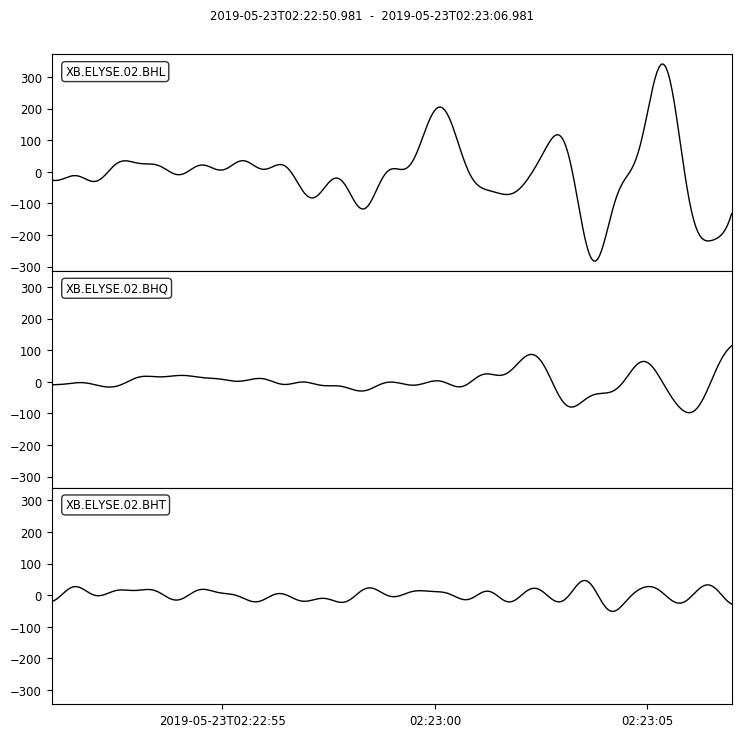

P:EH45Tcold


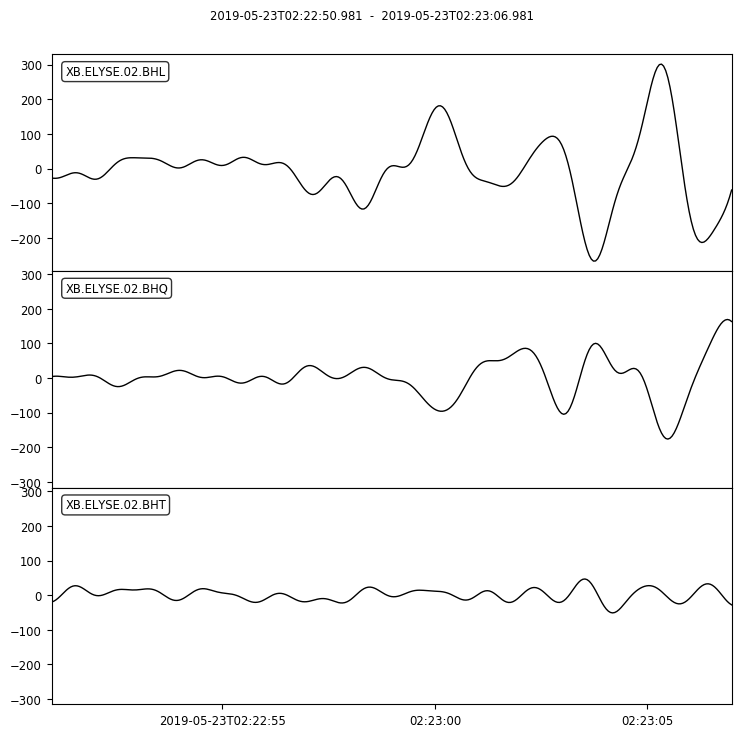

P:EH45TcoldCrust1b


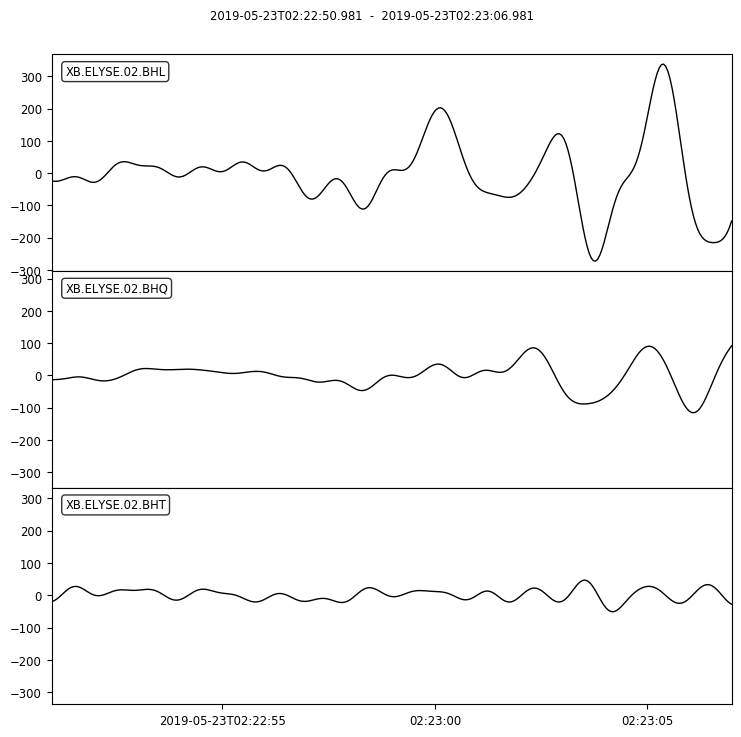

P:Gudkova


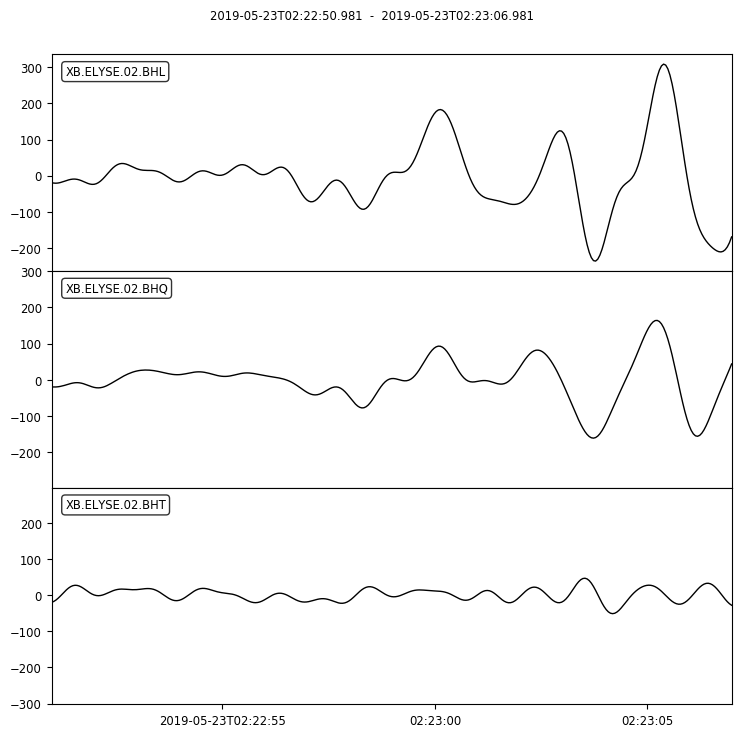

P:LFAK


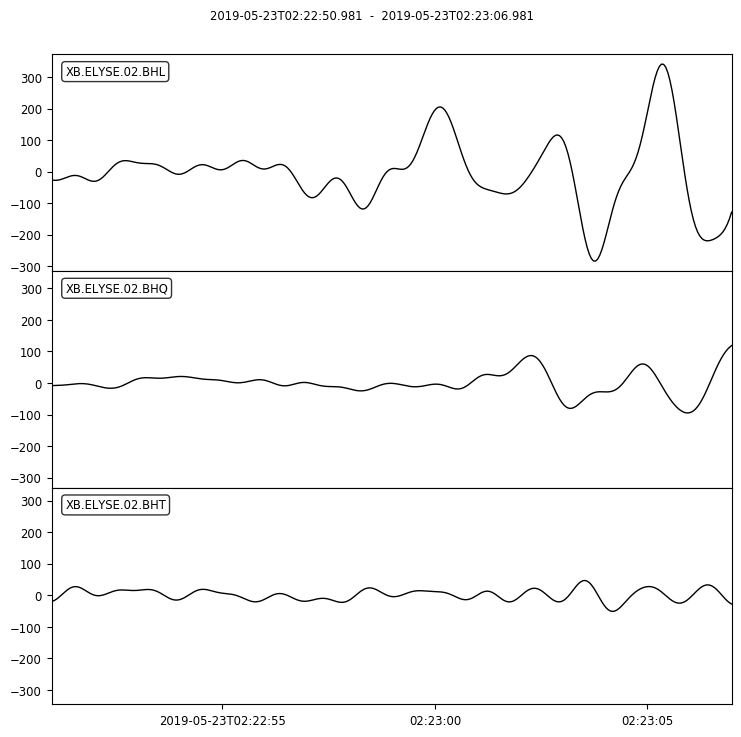

P:MAAK


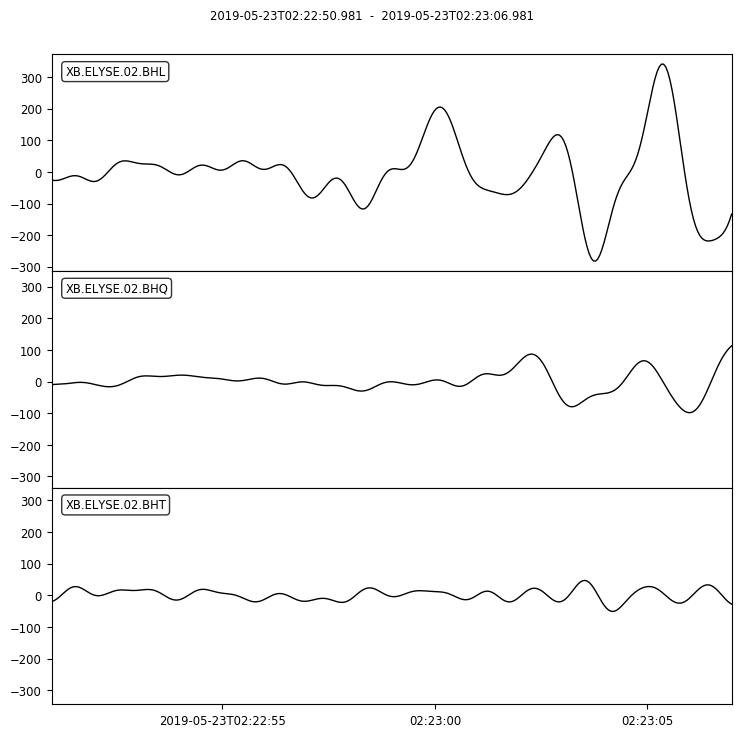

P:TAYAK


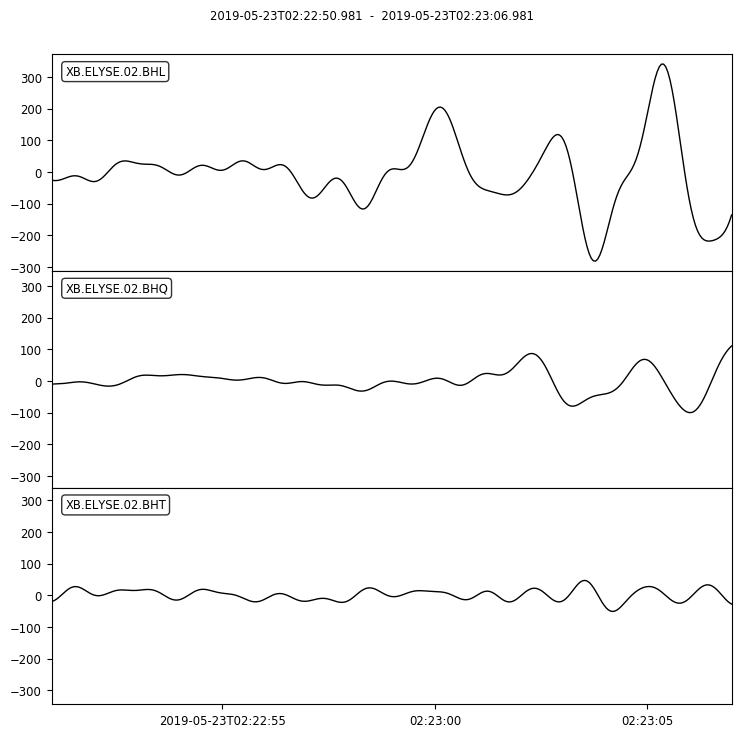

S:DWAK


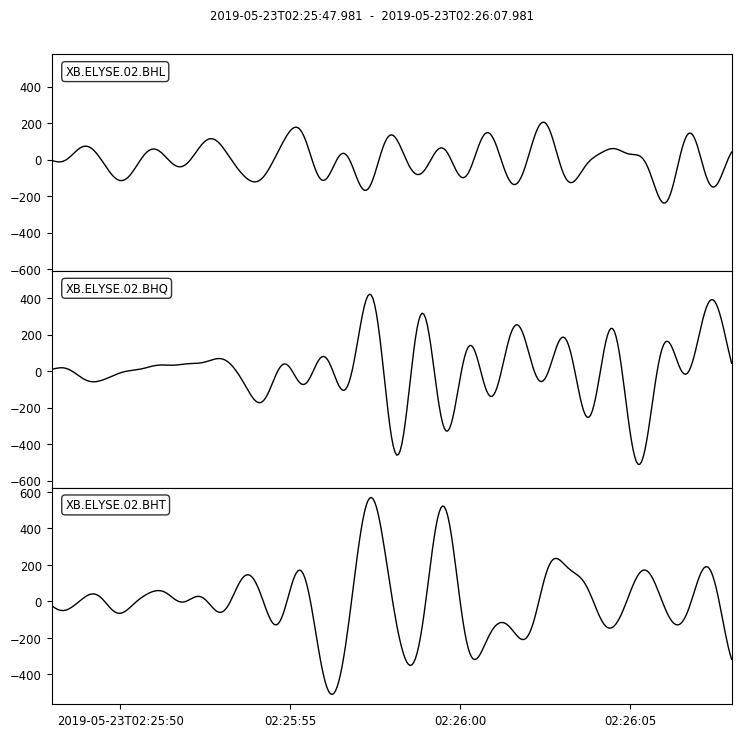

S:EH45Tcold


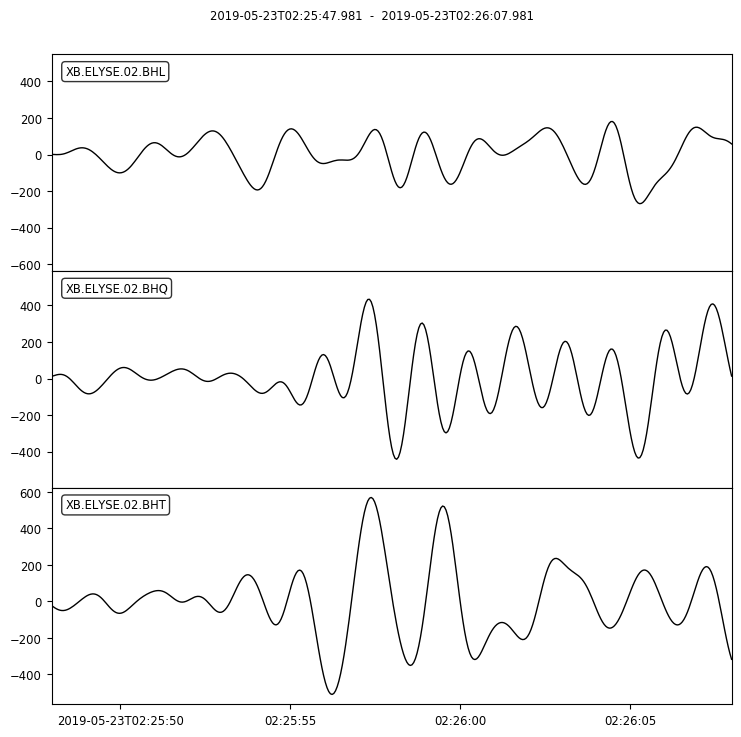

S:EH45TcoldCrust1b


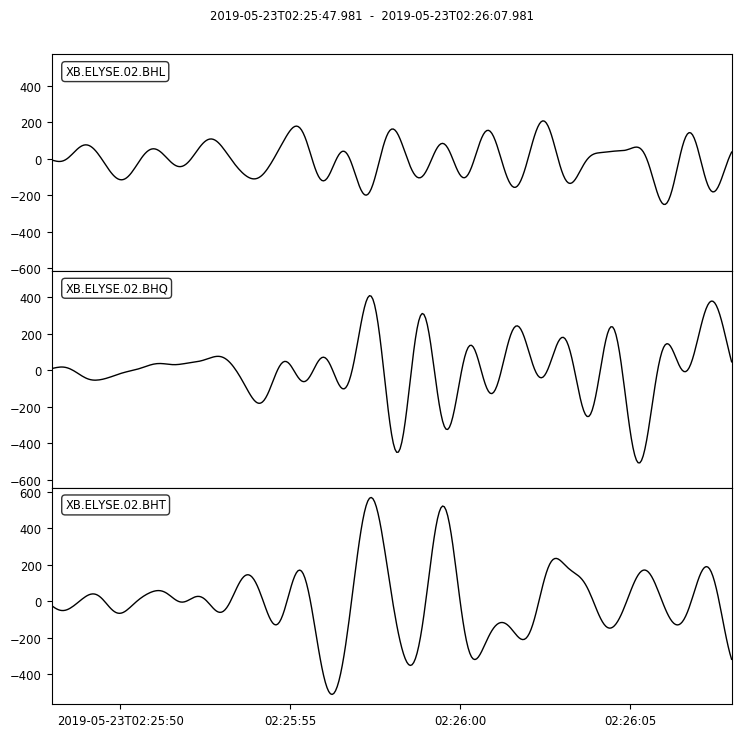

S:Gudkova


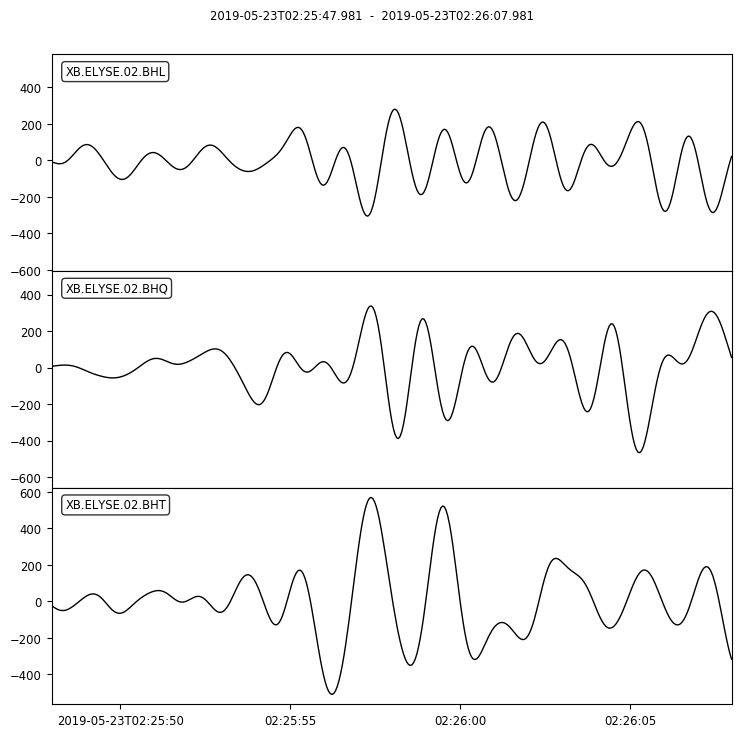

S:LFAK


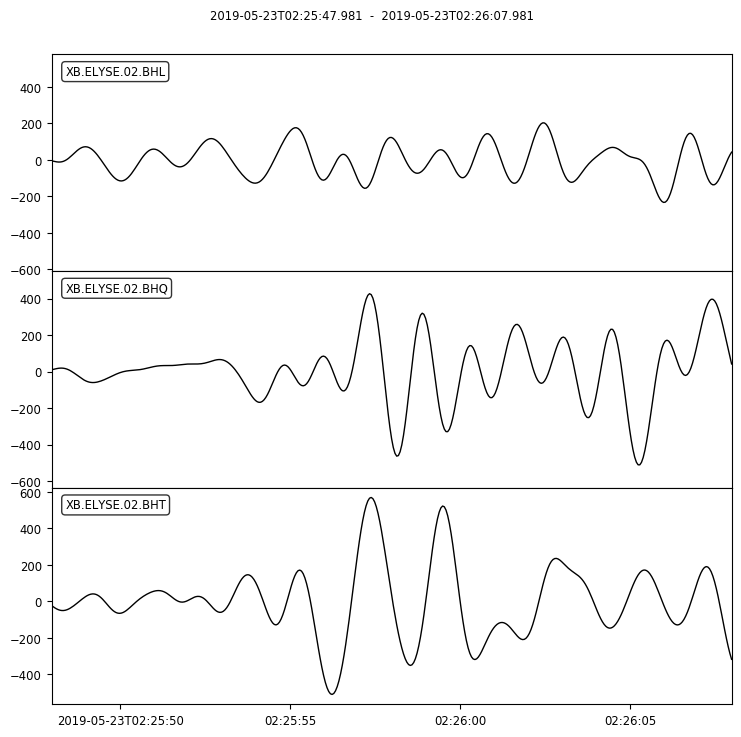

S:MAAK


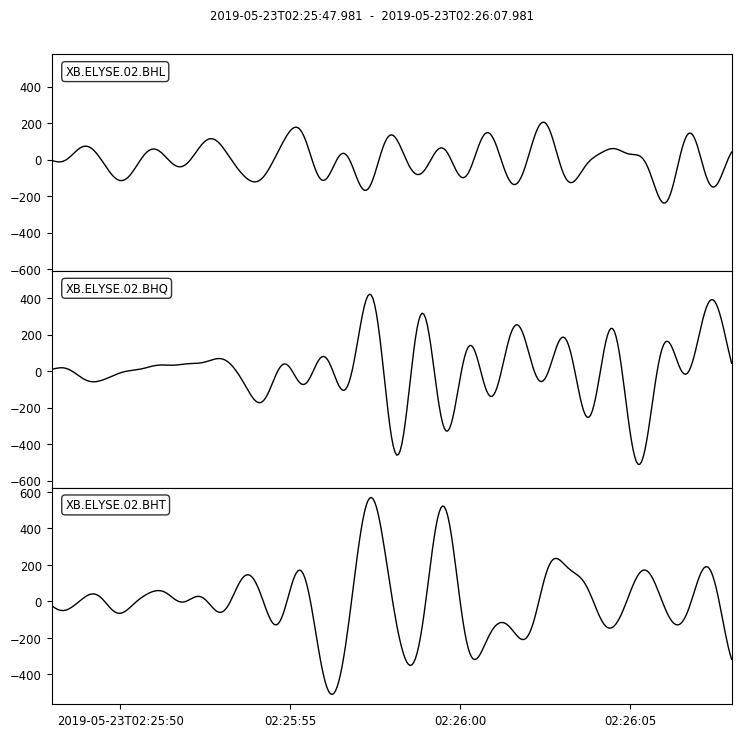

S:TAYAK


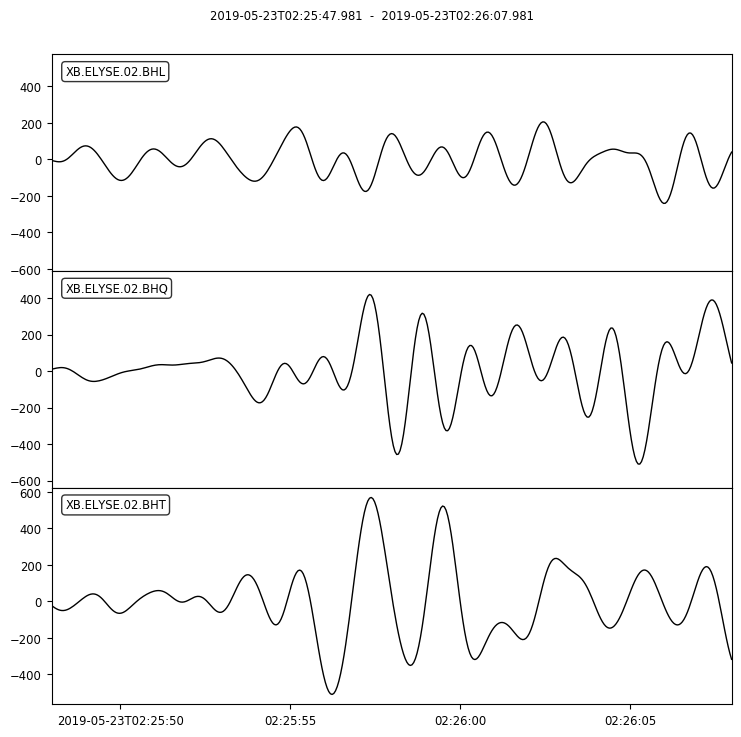

In [8]:
#P-wave
model_ls = ['DWAK', 'EH45Tcold', 'EH45TcoldCrust1b', 'Gudkova', 'LFAK', 'MAAK', 'TAYAK']
model_Pangles = [28,56.5,19,1.8,30,27.5,26.5]
model_Sangles = [24,58,19.5,2,26,24,23]

n = 0
for a in model_Pangles:
    print('P:' + model_ls[n])
    stP = stP_og.copy()
    hhQ,hhL = rotate(stP[1].data, stP[2].data, a)
    t1, t2, t3 = Trace(stP[0].data, header=headerP), Trace(hhQ, header=headerP), Trace(hhL, header=headerP)
    stP_LQ = Stream(traces=[t1,t2,t3])
    stP_LQ[0].stats.component = 'T'
    stP_LQ[1].stats.component = 'Q'
    stP_LQ[2].stats.component = 'L'
    
    stP_LQ.plot(equal_scale=True);
    n += 1
    
#S-wave
n = 0
for a in model_Sangles:
    print('S:' + model_ls[n])
    stS = stS_og.copy()
    hhQ,hhL = rotate(stS[1].data, stS[2].data, a)
    t1, t2, t3 = Trace(stS[0].data, header=headerS), Trace(hhQ, header=headerS), Trace(hhL, header=headerS)
    stS_LQ = Stream(traces=[t1,t2,t3])
    stS_LQ[0].stats.component = 'T'
    stS_LQ[1].stats.component = 'Q'
    stS_LQ[2].stats.component = 'L'
    
    stS_LQ.plot(equal_scale=True);
    n += 1

# S0235b

In [9]:
begin = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

hhe = stf[0].data
hhn = stf[1].data
hhz = stf[2].data

hhT,hhR = rotate(hhe,hhn,261)

streamRT = stf.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

In [10]:
stP = stf.slice(starttime=begin-5,endtime=begin+2)
stS = stf.slice(starttime=end-5, endtime=end+15)

In [11]:
headerP = stP_og[0].stats
headerS = stS_og[0].stats

P:DWAK


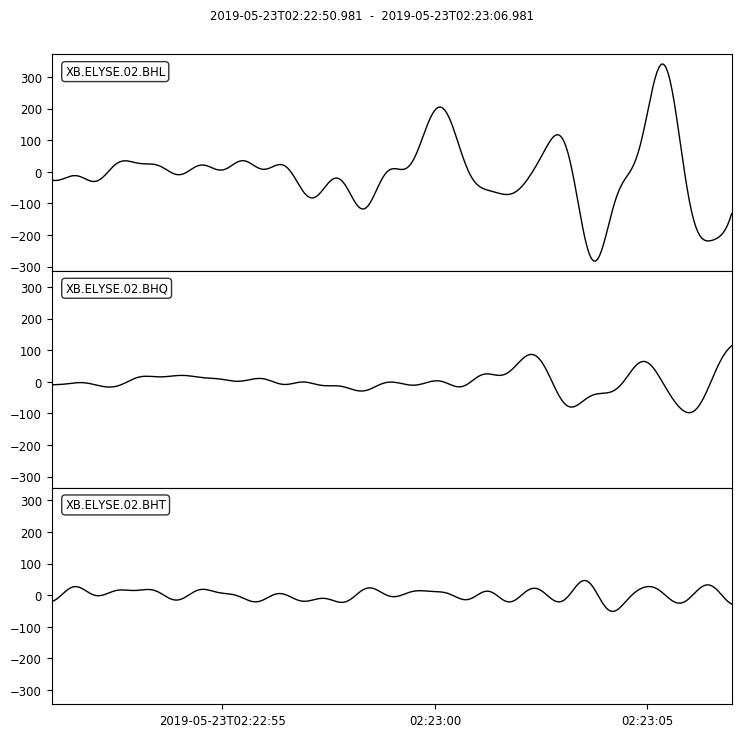

P:EH45Tcold


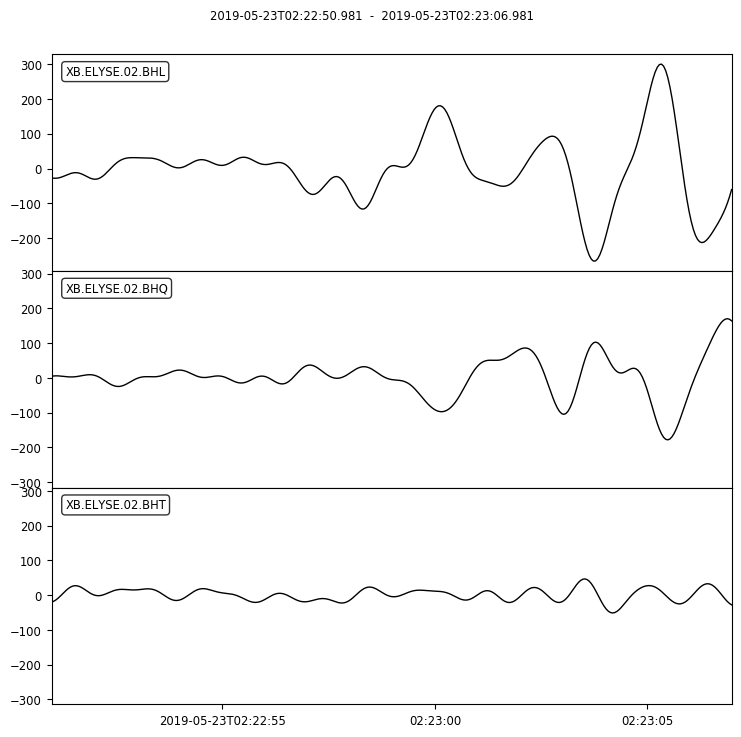

P:EH45TcoldCrust1b


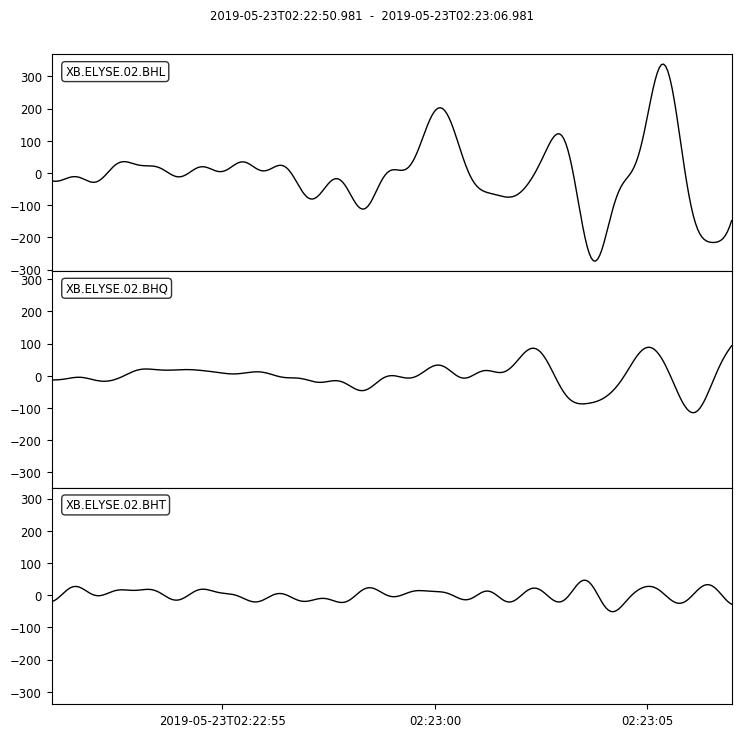

P:Gudkova


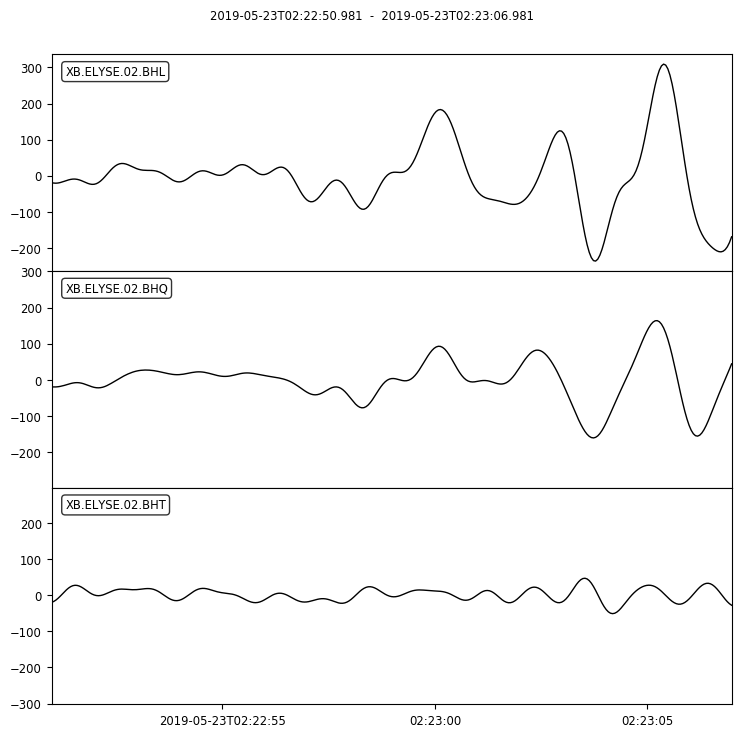

P:LFAK


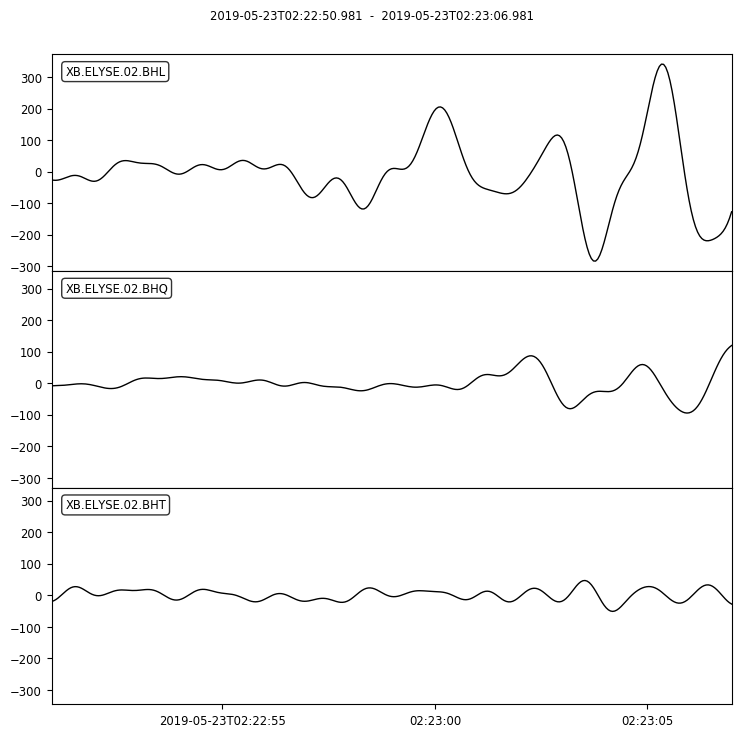

P:MAAK


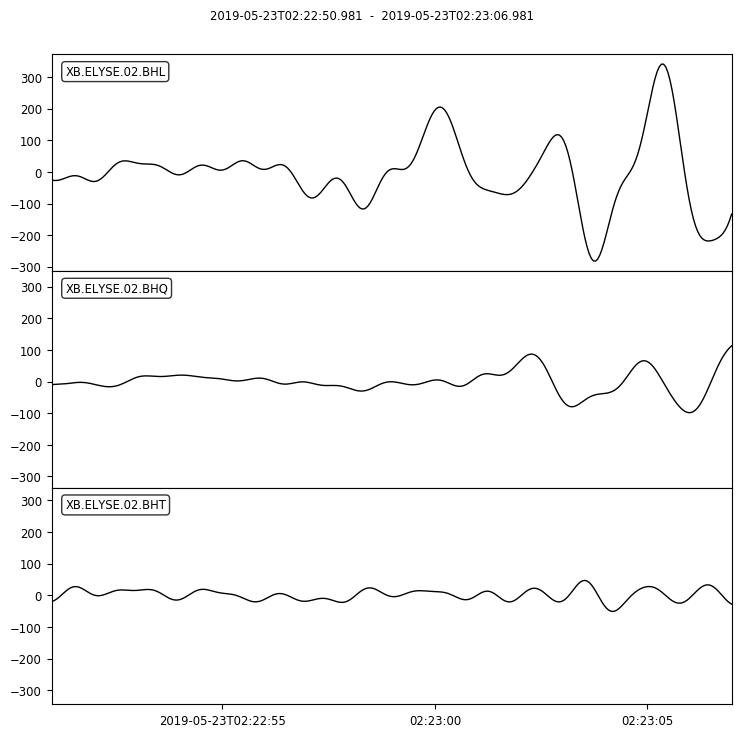

P:TAYAK


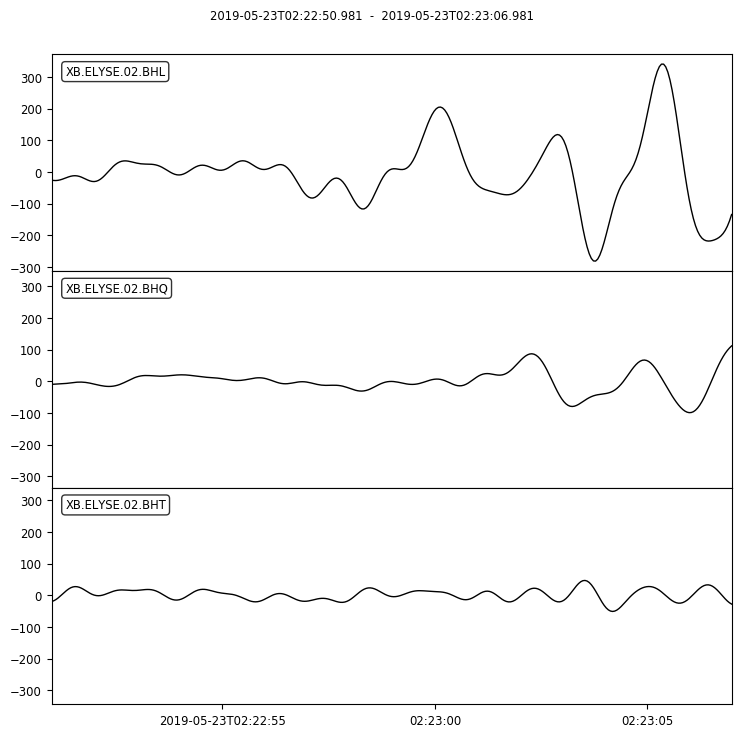

S:DWAK


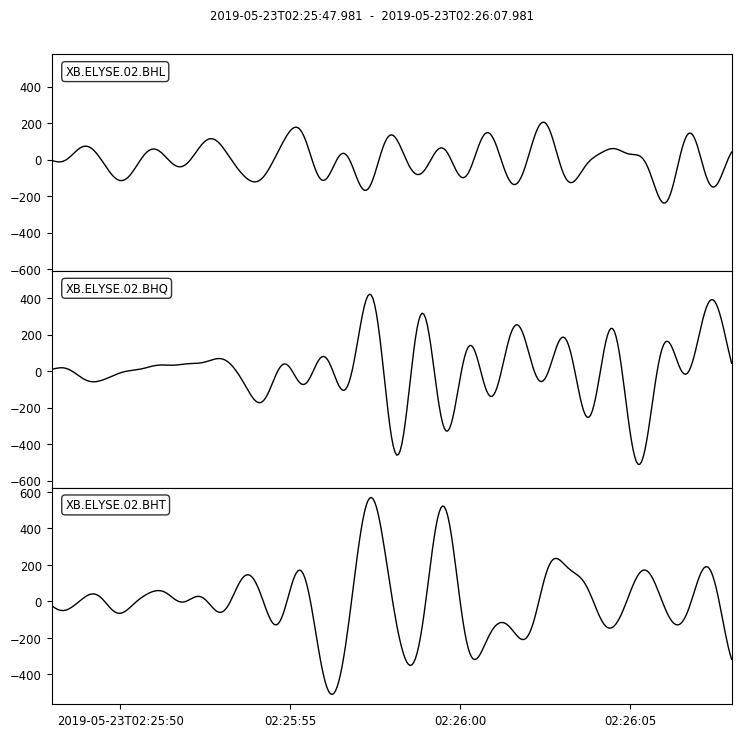

S:EH45Tcold


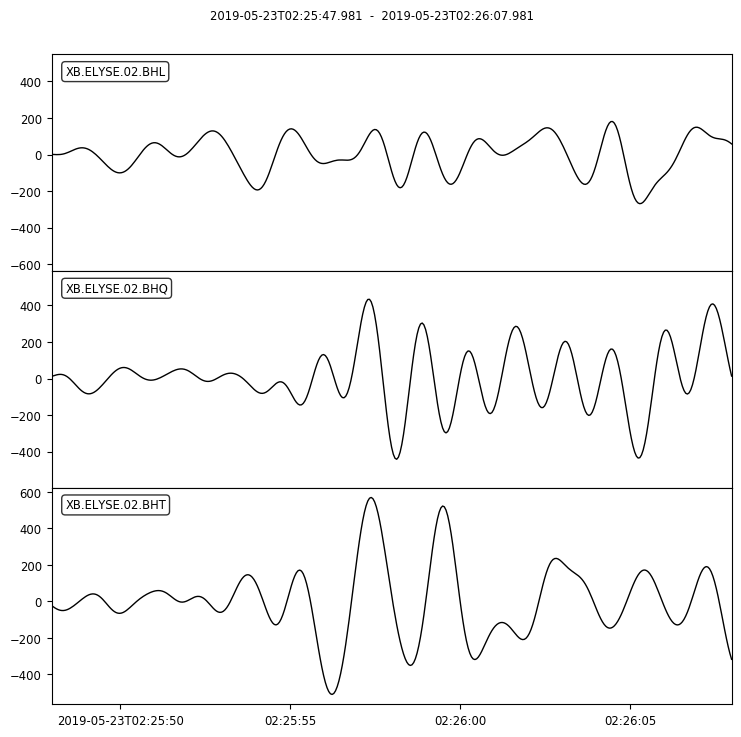

S:EH45TcoldCrust1b


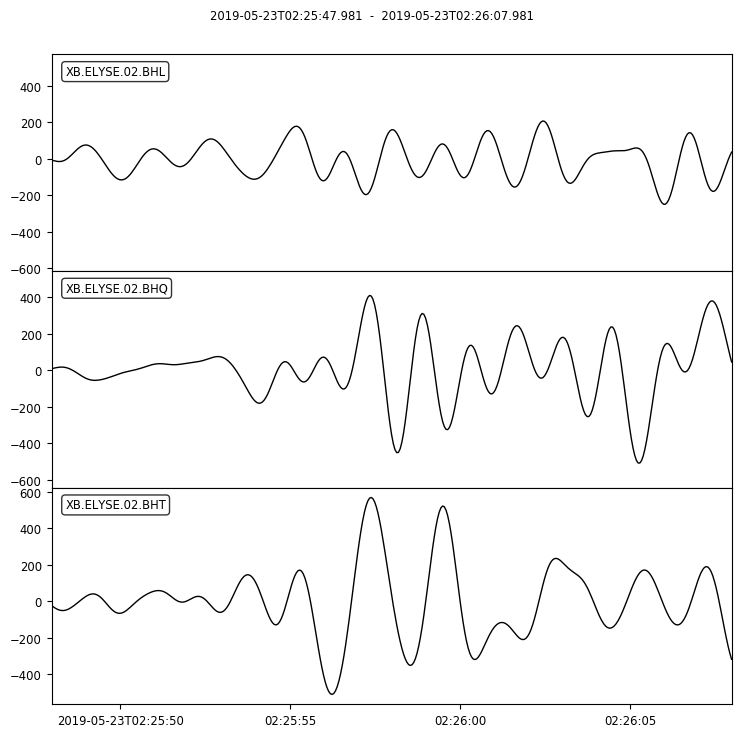

S:Gudkova


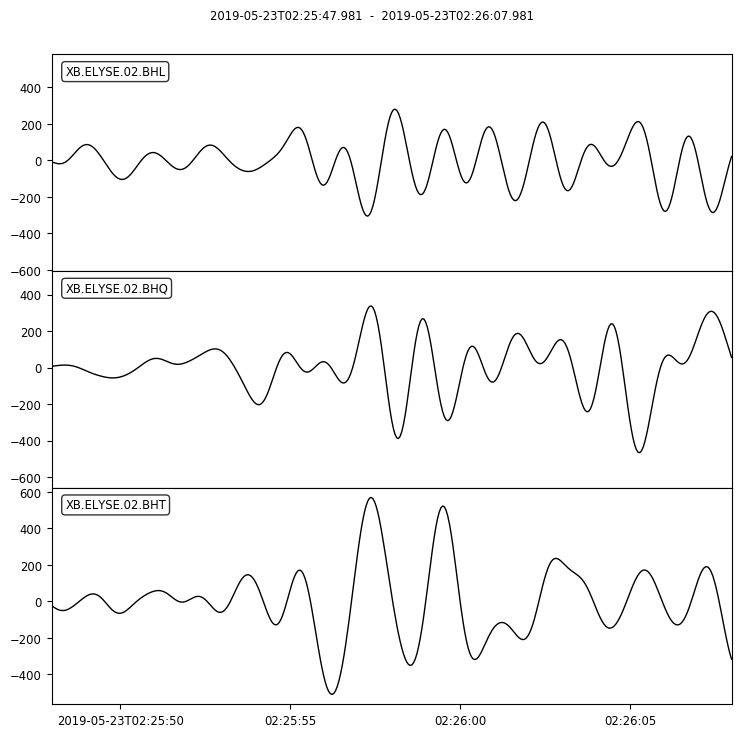

S:LFAK


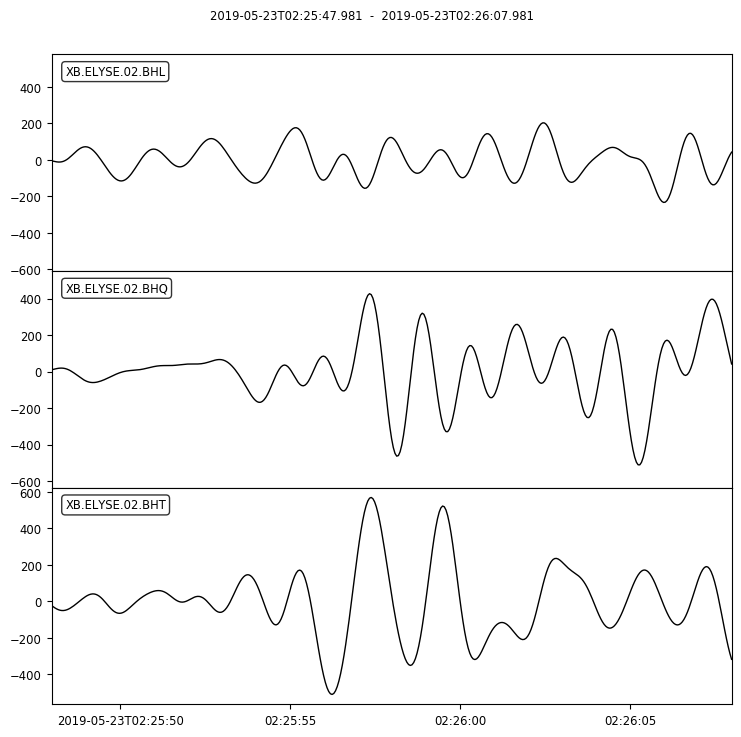

S:MAAK


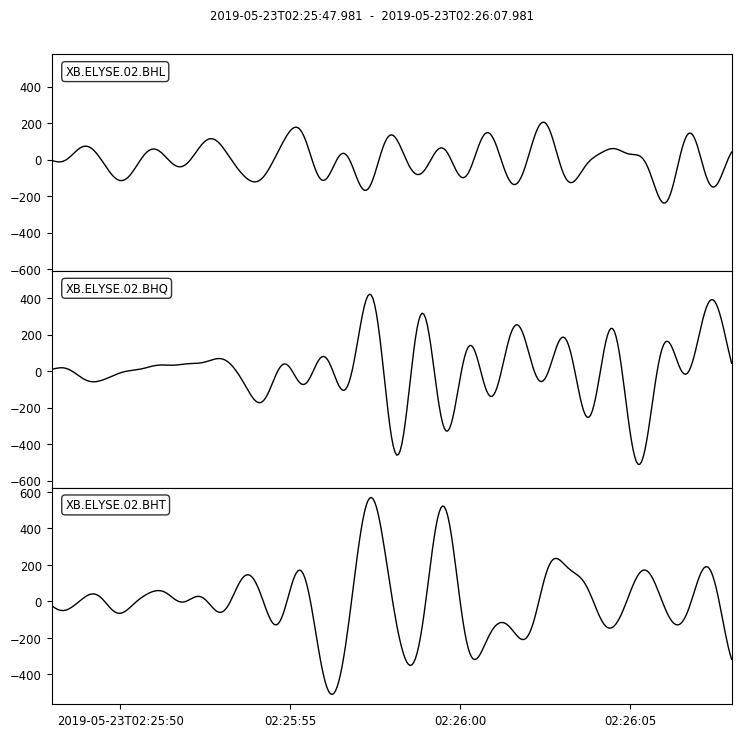

S:TAYAK


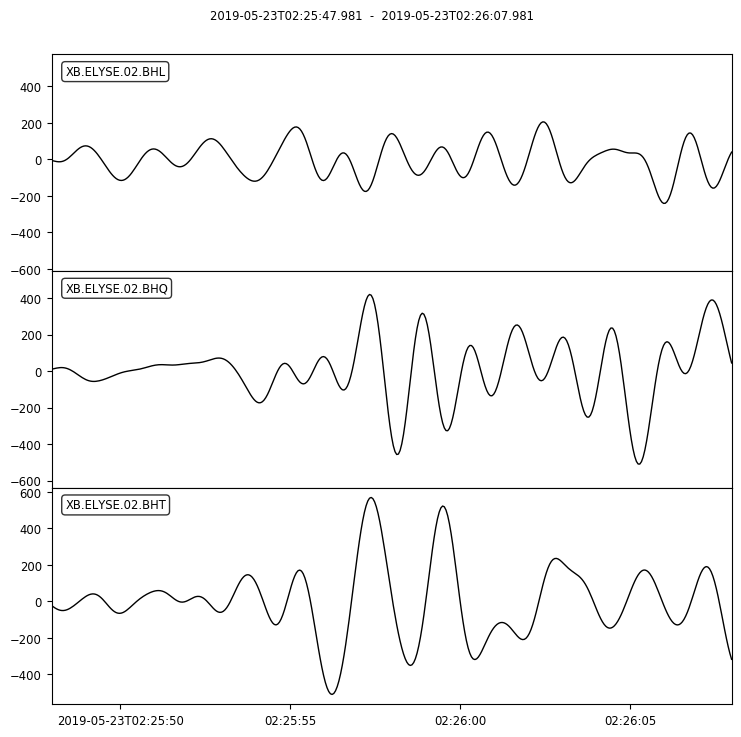

In [12]:
#P-wave
model_ls = ['DWAK', 'EH45Tcold', 'EH45TcoldCrust1b', 'Gudkova', 'LFAK', 'MAAK', 'TAYAK']
model_Pangles = [28,57,19.5,1.9,30.5,27.5,27]
model_Sangles = [24,58,20,2,26,24,23]

n = 0
for a in model_Pangles:
    print('P:' + model_ls[n])
    stP = stP_og.copy()
    hhQ,hhL = rotate(stP[1].data, stP[2].data, a)
    t1, t2, t3 = Trace(stP[0].data, header=headerP), Trace(hhQ, header=headerP), Trace(hhL, header=headerP)
    stP_LQ = Stream(traces=[t1,t2,t3])
    stP_LQ[0].stats.component = 'T'
    stP_LQ[1].stats.component = 'Q'
    stP_LQ[2].stats.component = 'L'
    
    stP_LQ.plot(equal_scale=True);
    n += 1
    
#S-wave
n = 0
for a in model_Sangles:
    print('S:' + model_ls[n])
    stS = stS_og.copy()
    hhQ,hhL = rotate(stS[1].data, stS[2].data, a)
    t1, t2, t3 = Trace(stS[0].data, header=headerS), Trace(hhQ, header=headerS), Trace(hhL, header=headerS)
    stS_LQ = Stream(traces=[t1,t2,t3])
    stS_LQ[0].stats.component = 'T'
    stS_LQ[1].stats.component = 'Q'
    stS_LQ[2].stats.component = 'L'
    
    stS_LQ.plot(equal_scale=True);
    n += 1

# S0325a

In [13]:
begin = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
hhe = stf[0].data
hhn = stf[1].data
hhz = stf[2].data

hhT,hhR = rotate(hhe,hhn,303)

streamRT = stf.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

In [14]:
stP = stf.slice(starttime=begin-5,endtime=begin+3)
stS = stf.slice(starttime=end-5, endtime=end+15)

In [15]:
headerP = stP_og[0].stats
headerS = stS_og[0].stats

P:DWAK


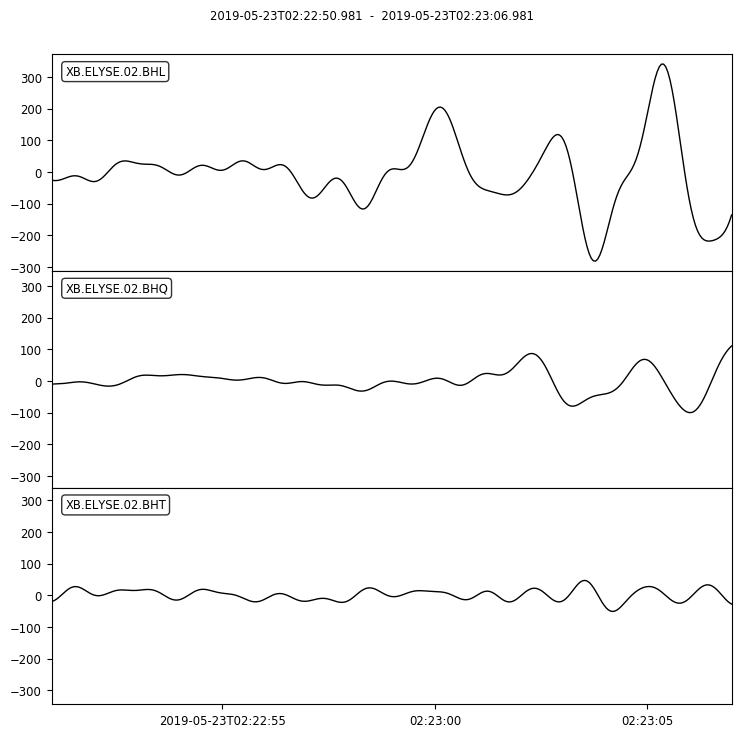

P:EH45Tcold


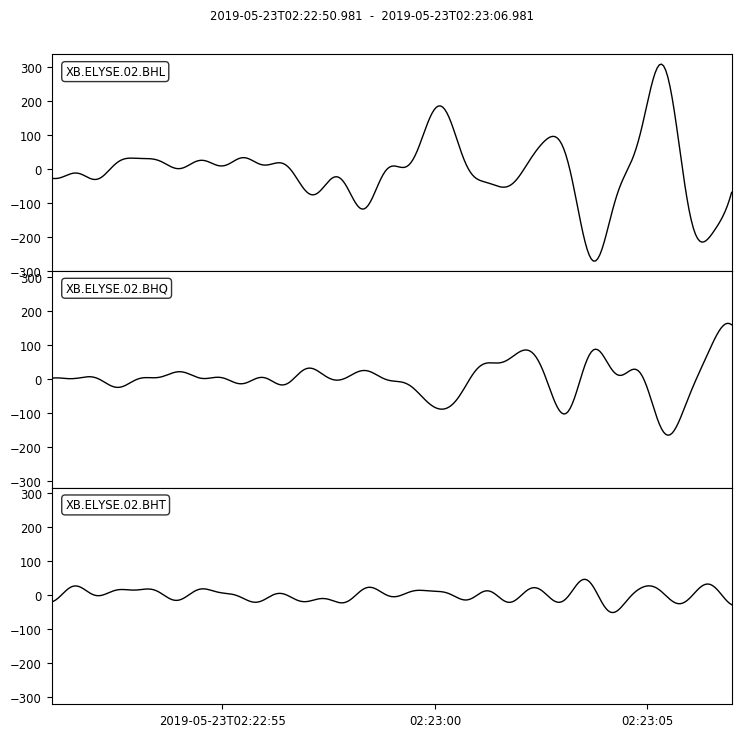

P:EH45TcoldCrust1b


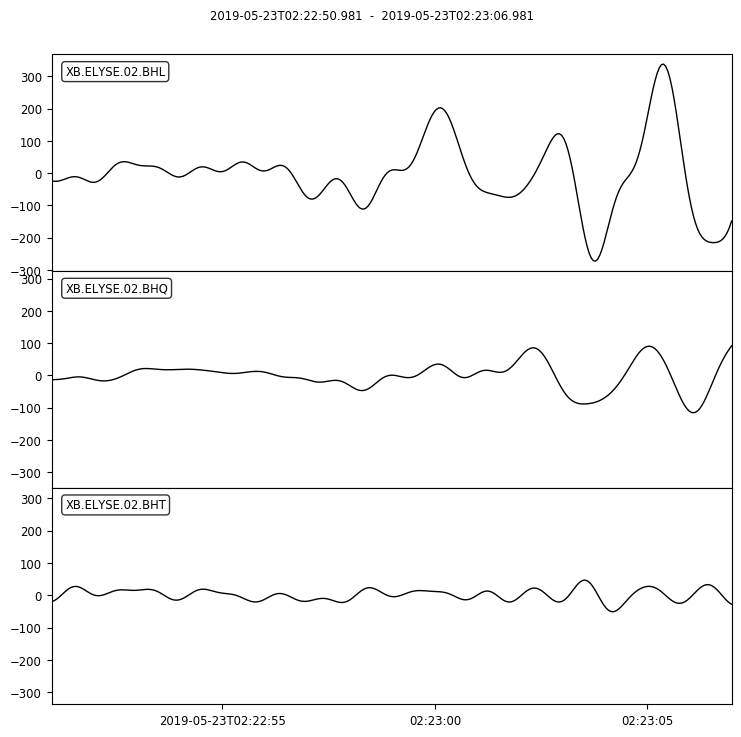

P:Gudkova


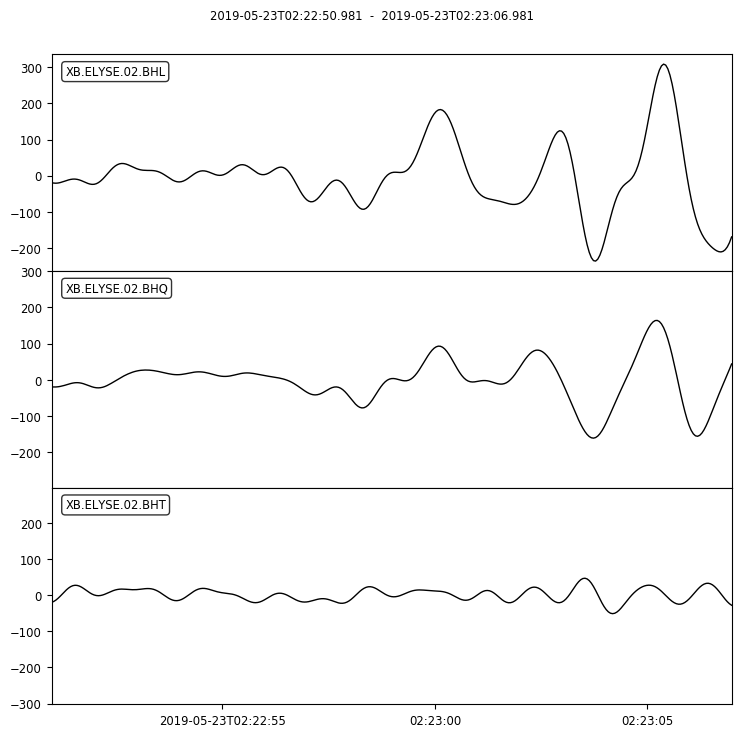

P:LFAK


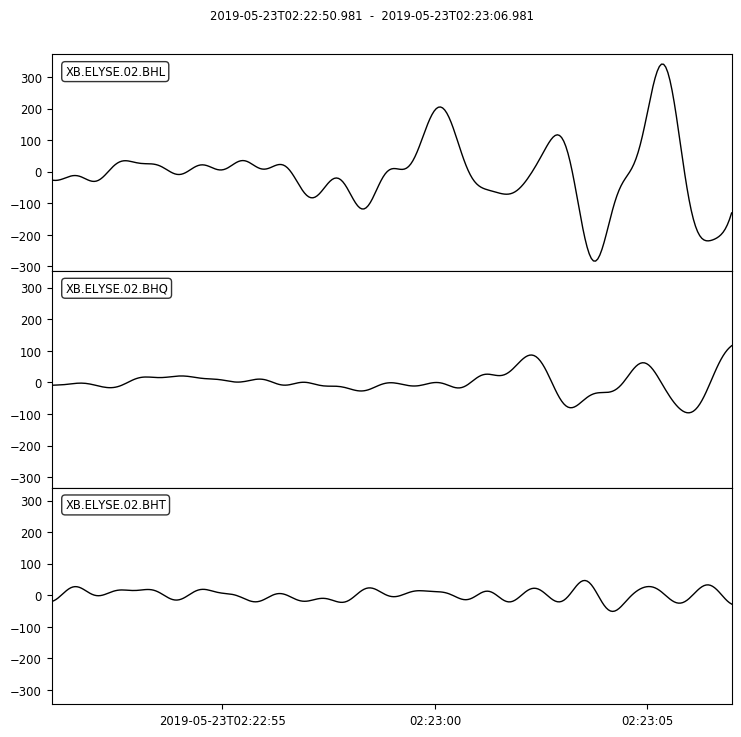

P:MAAK


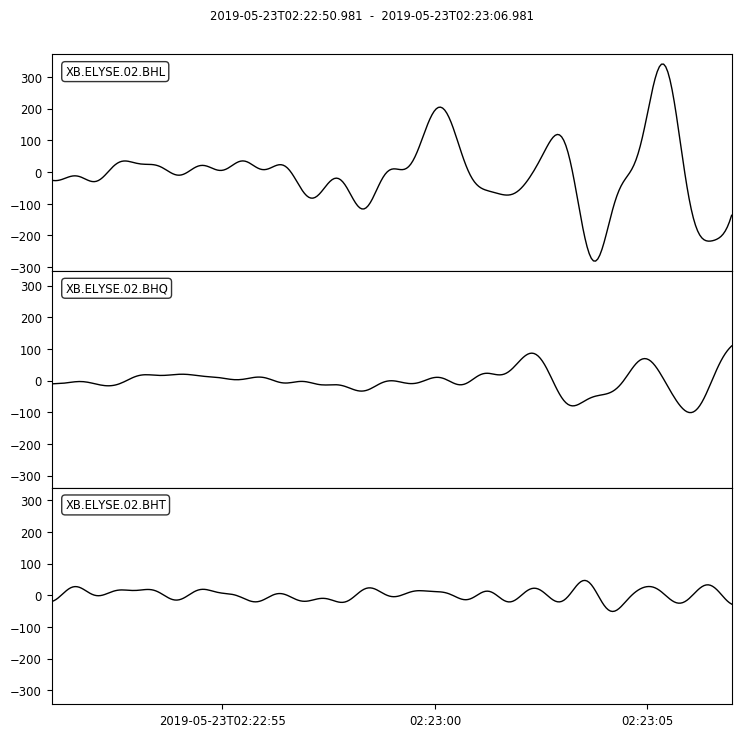

P:TAYAK


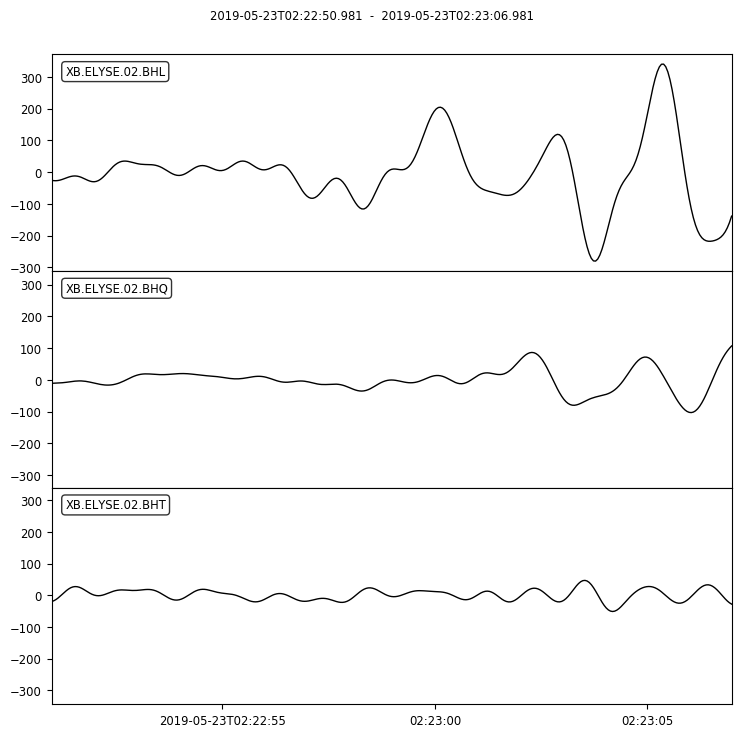

S:DWAK


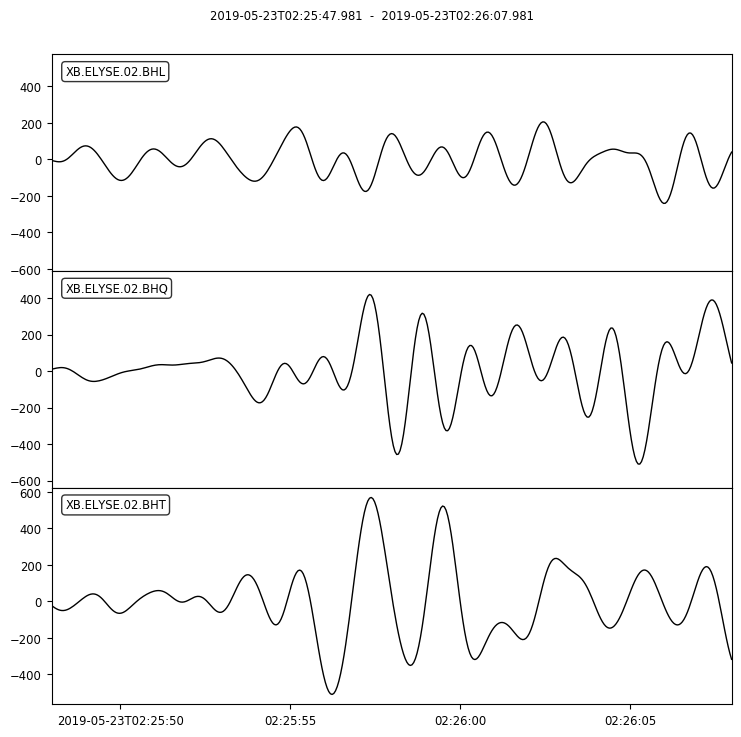

S:EH45Tcold


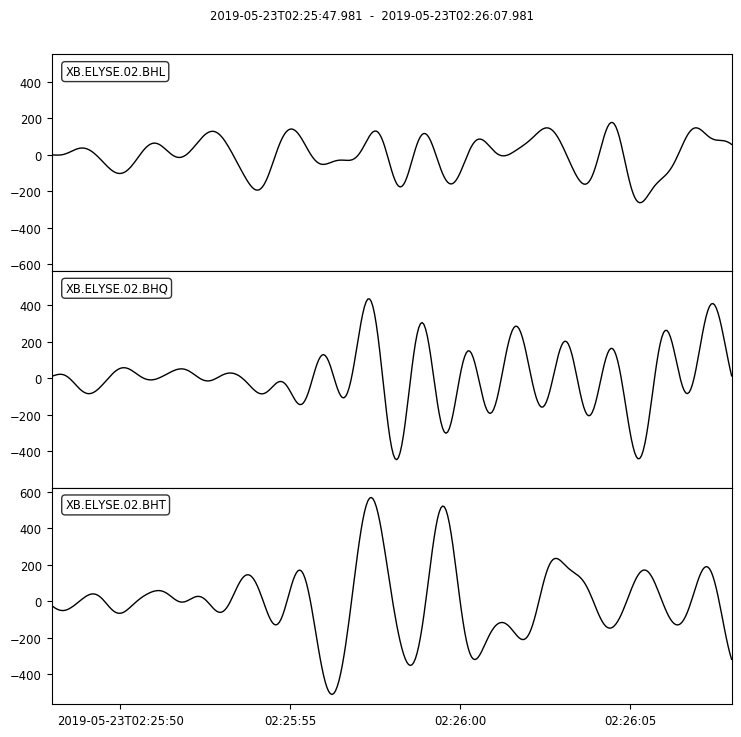

S:EH45TcoldCrust1b


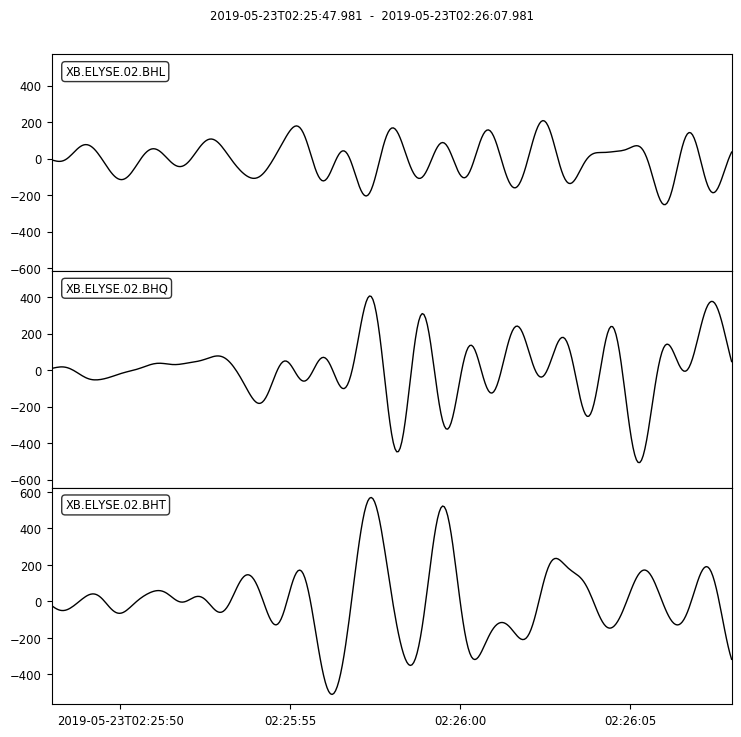

S:Gudkova


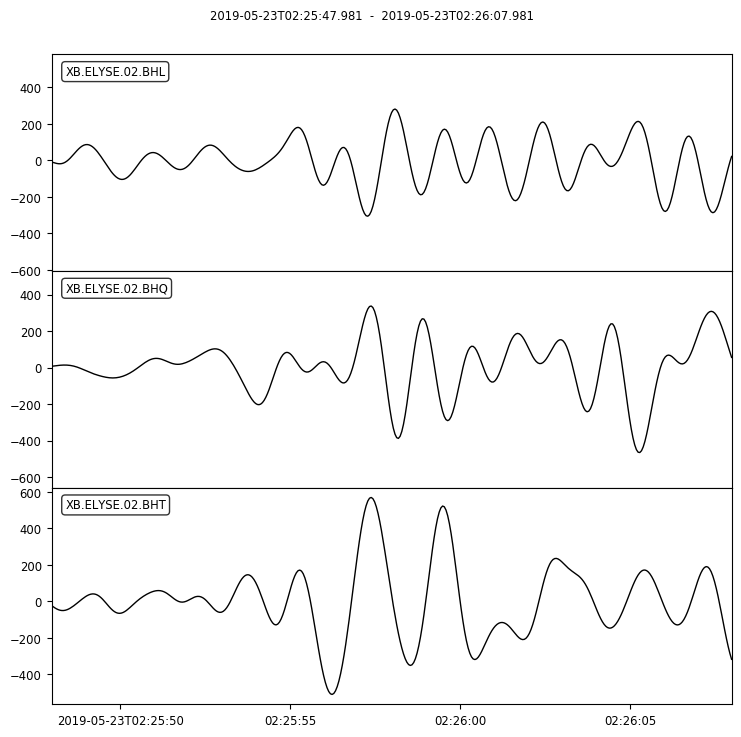

S:LFAK


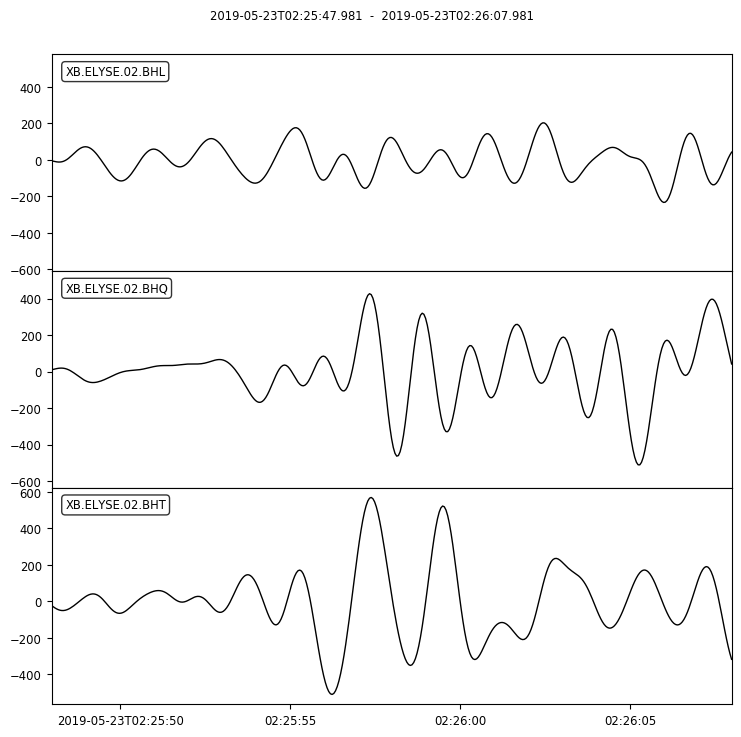

S:MAAK


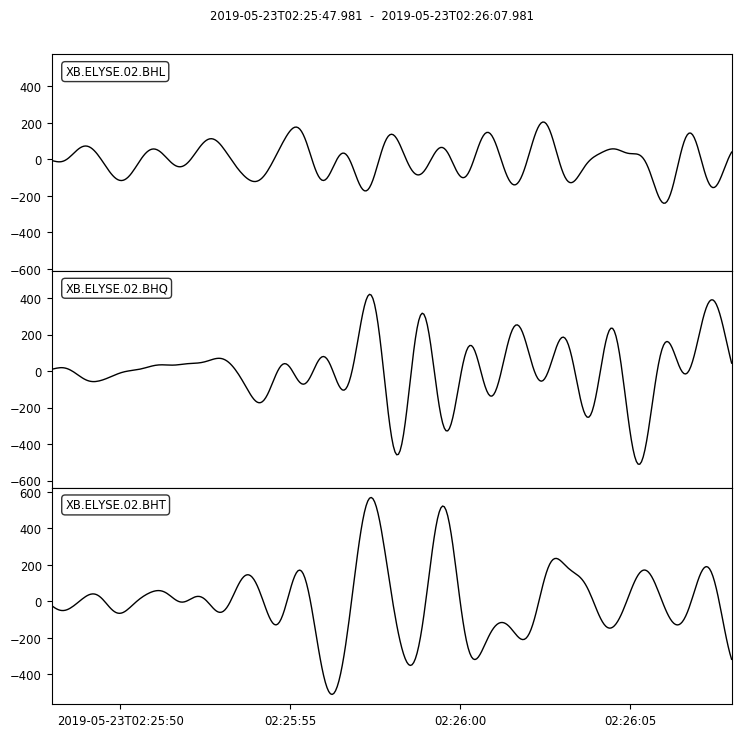

S:TAYAK


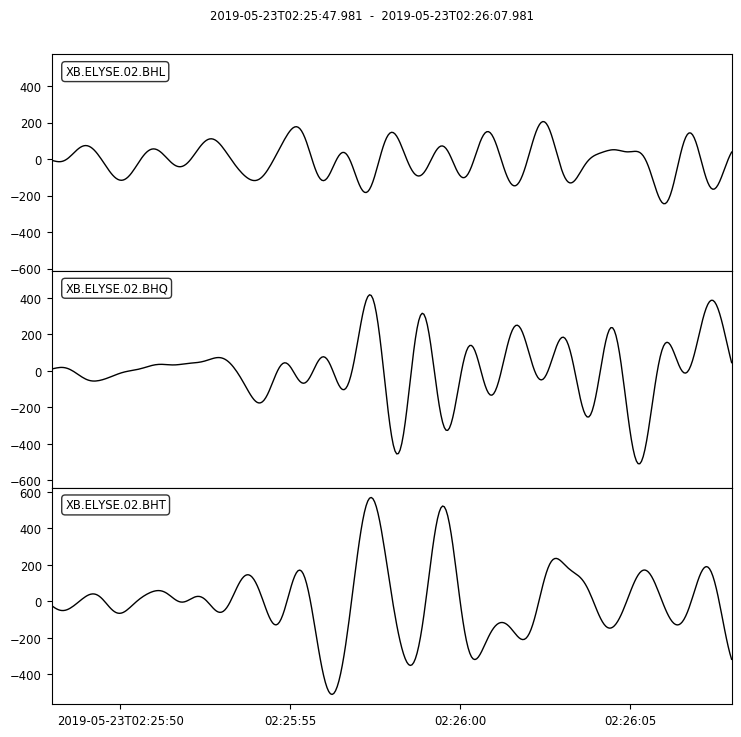

In [16]:
#P-wave
model_ls = ['DWAK', 'EH45Tcold', 'EH45TcoldCrust1b', 'Gudkova', 'LFAK', 'MAAK', 'TAYAK']
model_Pangles = [26.5,54,19,1.8,29,26,25]
model_Sangles = [23,57,18.7,1.9,26,23.5,22]

n = 0
for a in model_Pangles:
    print('P:' + model_ls[n])
    stP = stP_og.copy()
    hhQ,hhL = rotate(stP[1].data, stP[2].data, a)
    t1, t2, t3 = Trace(stP[0].data, header=headerP), Trace(hhQ, header=headerP), Trace(hhL, header=headerP)
    stP_LQ = Stream(traces=[t1,t2,t3])
    stP_LQ[0].stats.component = 'T'
    stP_LQ[1].stats.component = 'Q'
    stP_LQ[2].stats.component = 'L'
    
    stP_LQ.plot(equal_scale=True);
    n += 1
    
#S-wave
n = 0
for a in model_Sangles:
    print('S:' + model_ls[n])
    stS = stS_og.copy()
    hhQ,hhL = rotate(stS[1].data, stS[2].data, a)
    t1, t2, t3 = Trace(stS[0].data, header=headerS), Trace(hhQ, header=headerS), Trace(hhL, header=headerS)
    stS_LQ = Stream(traces=[t1,t2,t3])
    stS_LQ[0].stats.component = 'T'
    stS_LQ[1].stats.component = 'Q'
    stS_LQ[2].stats.component = 'L'
    
    stS_LQ.plot(equal_scale=True);
    n += 1